# 工业场景全流程！保险金额预估机器学习开发并部署服务到云端

本篇内容从头开始构建机器学习管道，使用 Flask 框架构建 Web 应用程序，并部署到云服务器上的过程。具体包括：


- 何为机器学习应用部署
- 基于 PyCaret 开发机器学习全流程
- 基于 Flask 搭建简易前端 Web 应用程序
- 在 Heroku 云上部署机器学习应用

作者：ShowMeAI
链接：https://juejin.cn/post/7144908639965282341
来源：稀土掘金
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

在企业的实际生产中，我们经常会把机器学习模型构建成服务形态，这样协作的开发同事可以通过接口（API）来访问模型服务，完成预估任务，这被称为部署机器学习应用过程。

更全一点说，生产中使用机器学习管道有两种广泛的方式：

- 批量预测

将模型或管道存储在磁盘中，定期运行脚本，加载模型和数据，生成预测并将输出写入磁盘。这种情况下，多个预测会并行。它对于时效性要求不高。

- 在线预测

需要实时预测，大家使用到的很多 app，其实都是输入信息，然后在单击提交按钮时，实时预估生成预测的。比如你在电商平台输入搜索词，点击查询，可以看到模型排序好的结果列表返回。
本教程中，我们讲解的是『在线预测』这种模式。我们将首先使用 PyCaret 在 Python 中构建机器学习管道，然后使用 Flask 构建 Web 应用程序，最后将所有这些部署在 Heroku 云上。

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

# 获取pycaret.datasets里的样例数据

In [5]:
from pycaret.datasets import get_data
all_datasets = get_data('index')

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


## 获取保险费用样例数据

In [6]:

insurance_data = get_data('insurance')

# 查看是否有空值，属性是否正确
insurance_data.info()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 对保费数据进行描述分析

In [7]:
insurance_data.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [8]:
juice = get_data('juice')

,Dataset,Data Types,Default Task,Target Variable 1,Target Variable 2,# Instances,# Attributes,Missing Values
0,anomaly,Multivariate,Anomaly Detection,NaN,NaN,1000,10,N
1,france,Multivariate,Association Rule Mining,InvoiceNo,Description,8557,8,N
2,germany,Multivariate,Association Rule Mining,InvoiceNo,Description,9495,8,N
3,bank,Multivariate,Classification (Binary),deposit,NaN,45211,17,N
4,blood,Multivariate,Classification (Binary),Class,NaN,748,5,N
5,cancer,Multivariate,Classification (Binary),Class,NaN,683,10,N
6,credit,Multivariate,Classification (Binary),default,NaN,24000,24,N
7,diabetes,Multivariate,Classification (Binary),Class variable,NaN,768,9,N
8,electrical_grid,Multivariate,Classification (Binary),stabf,NaN,10000,14,N
9,employee,Multivariate,Classification (Binary),left,NaN,14999,10,N


,Id,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,1,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,2,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,3,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,4,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,5,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


# Experiment 1

In [9]:
from pycaret.regression import *

In [10]:
s = setup(data, target = 'charges', session_id = 123)

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


In [11]:
lr = create_model('lr')

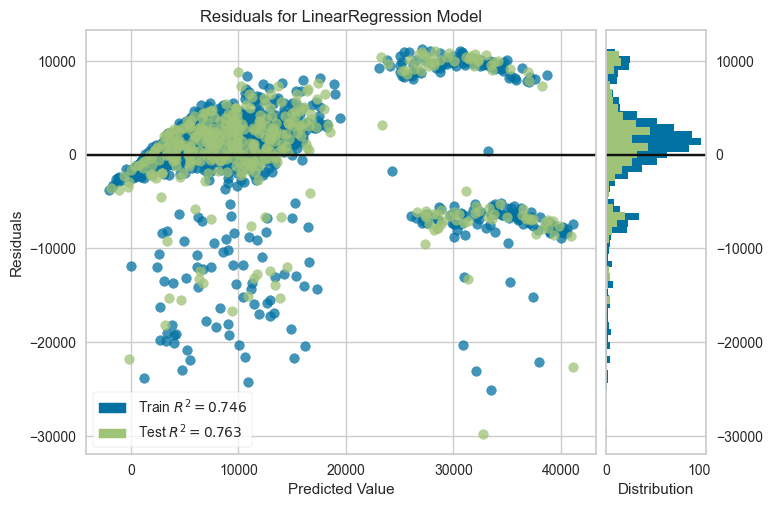

In [12]:
plot_model(lr)

# Experiment 2

In [8]:
s2 = setup(data, target = 'charges', session_id = 123,
           normalize = True,
           polynomial_features = True, trigonometry_features = True, feature_interaction=True,
           bin_numeric_features= ['age', 'bmi'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1338, 7)"
4,Missing Values,False
5,Numeric Features,2
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [9]:
s2[0].columns

Index(['age_Power2', 'bmi_Power2', 'sex_female', 'children_0', 'children_1',
       'children_2', 'children_3', 'children_4', 'children_5', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest', 'age_0.0', 'age_1.0', 'age_10.0', 'age_11.0',
       'age_2.0', 'age_3.0', 'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0',
       'age_8.0', 'age_9.0', 'bmi_0.0', 'bmi_1.0', 'bmi_10.0', 'bmi_11.0',
       'bmi_2.0', 'bmi_3.0', 'bmi_4.0', 'bmi_5.0', 'bmi_6.0', 'bmi_7.0',
       'bmi_8.0', 'bmi_9.0', 'smoker_yes_multiply_bmi_5.0',
       'region_southeast_multiply_age_Power2',
       'bmi_Power2_multiply_smoker_yes', 'age_Power2_multiply_smoker_yes',
       'children_0_multiply_bmi_Power2',
       'region_southeast_multiply_bmi_Power2',
       'children_0_multiply_smoker_yes', 'sex_female_multiply_bmi_Power2',
       'region_southeast_multiply_smoker_yes',
       'smoker_yes_multiply_children_0', 'smoker_yes_multiply_bmi_Power2',
       'children_0

In [10]:
lr = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2476.5333,1.792665e+07,4233.9880,0.8929,0.3878,0.2842
1,3355.1345,3.404316e+07,5834.6515,0.8021,0.4613,0.3304
2,2919.7578,2.261994e+07,4756.0423,0.7136,0.5533,0.3790
3,2964.9649,2.283861e+07,4778.9761,0.8093,0.5456,0.4029
4,3097.0904,2.838265e+07,5327.5369,0.7889,0.5248,0.2831
5,2979.1330,2.035337e+07,4511.4710,0.8691,0.3543,0.2744
6,2687.7389,2.234181e+07,4726.7128,0.8480,0.4020,0.3279
7,3123.5060,2.697542e+07,5193.7863,0.8517,0.4707,0.3089
8,2813.0890,2.055905e+07,4534.2087,0.8672,0.3759,0.3151
9,3110.4590,2.651683e+07,5149.4496,0.8292,0.4661,0.3353


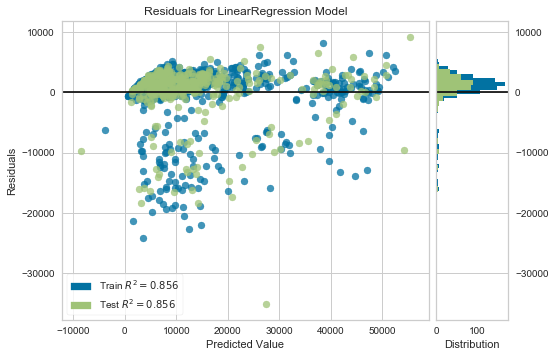

In [11]:
plot_model(lr)

In [12]:
save_model(lr, 'deployment_28042020')

Transformation Pipeline and Model Succesfully Saved


In [13]:
deployment_28042020 = load_model('deployment_28042020')

Transformation Pipeline and Model Sucessfully Loaded


In [14]:
deployment_28042020

[Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       ml_usecase='regression',
                                       numerical_features=[], target='charges',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 numeric_strategy='mean',
                                 target_variable=None)),
                 ('new_levels1',
                  New_Catagorical_Levels...
                 ('dummy', Dummify(target='charges')),
                 ('fix_perfect', Remove_100(target='charges')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', Empty()), ('fix_multi', Empty()),
                 ('dfs',
                  DFS_Classic(interactions

In [1]:
import requests
url = 'https://pycaret-insurance.herokuapp.com/predict_api'
pred = requests.post(url,json={'age':55, 'sex':'male', 'bmi':59, 'children':1, 'smoker':'male', 'region':'northwest'})
print(pred.json())

KeyboardInterrupt: 